# Player DF  
###### Handling NAN and categorical data

In [3]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder

playerDf = pd.read_csv("../../ncaa-players-2010-2021-yearly.csv")

#check which data are categorical
cat_features = [i for i in playerDf.columns if playerDf.dtypes[i] == 'object']

# playerDf['position'].unique()

def get_player_height(height):
    str_height = str(height)

    feet_inches = str_height.split('-')
    
    feet = feet_inches[0]
    if len(feet_inches) != 2:
        return 0

    height = 12 * int(feet) + int(feet_inches[1])
    return height

playerDf['height'] = playerDf.apply(lambda player: get_player_height(player.height), axis=1)

#replace 0 with mean value
playerDf['height'] = playerDf['height'].replace(0,playerDf['height'].mean())

#replace nan position with most frequent position
playerDf['position'].fillna(value=playerDf['position'].mode()[0],inplace=True)

#label encoding
le = LabelEncoder()
player_id = le.fit_transform(playerDf.player_id)
team_abbreviation = le.fit_transform(playerDf.team_abbreviation)
conference = le.fit_transform(playerDf.conference)
position = le.fit_transform(playerDf.position)
season = le.fit_transform(playerDf.season)

#assign new data type
playerDf = playerDf.assign(player_id=player_id,team_abbreviation=team_abbreviation,conference=conference,position=position,season=season)

playerDf.fillna(value=0,inplace=True)



# Filter method

assists                 0.699180
defensive_rebounds      0.820276
defensive_win_shares    0.740841
field_goal_attempts     0.984996
field_goals             0.989989
free_throw_attempts     0.899588
free_throws             0.911598
games_played            0.661780
games_started           0.833212
minutes_played          0.917777
offensive_rebounds      0.574192
offensive_win_shares    0.859382
personal_fouls          0.737128
points                  1.000000
points_produced         0.923109
steals                  0.774883
three_point_attempts    0.728125
three_pointers          0.718547
total_rebounds          0.774869
turnovers               0.857484
two_point_attempts      0.905498
two_pointers            0.885171
win_shares              0.889719
Name: points, dtype: float64

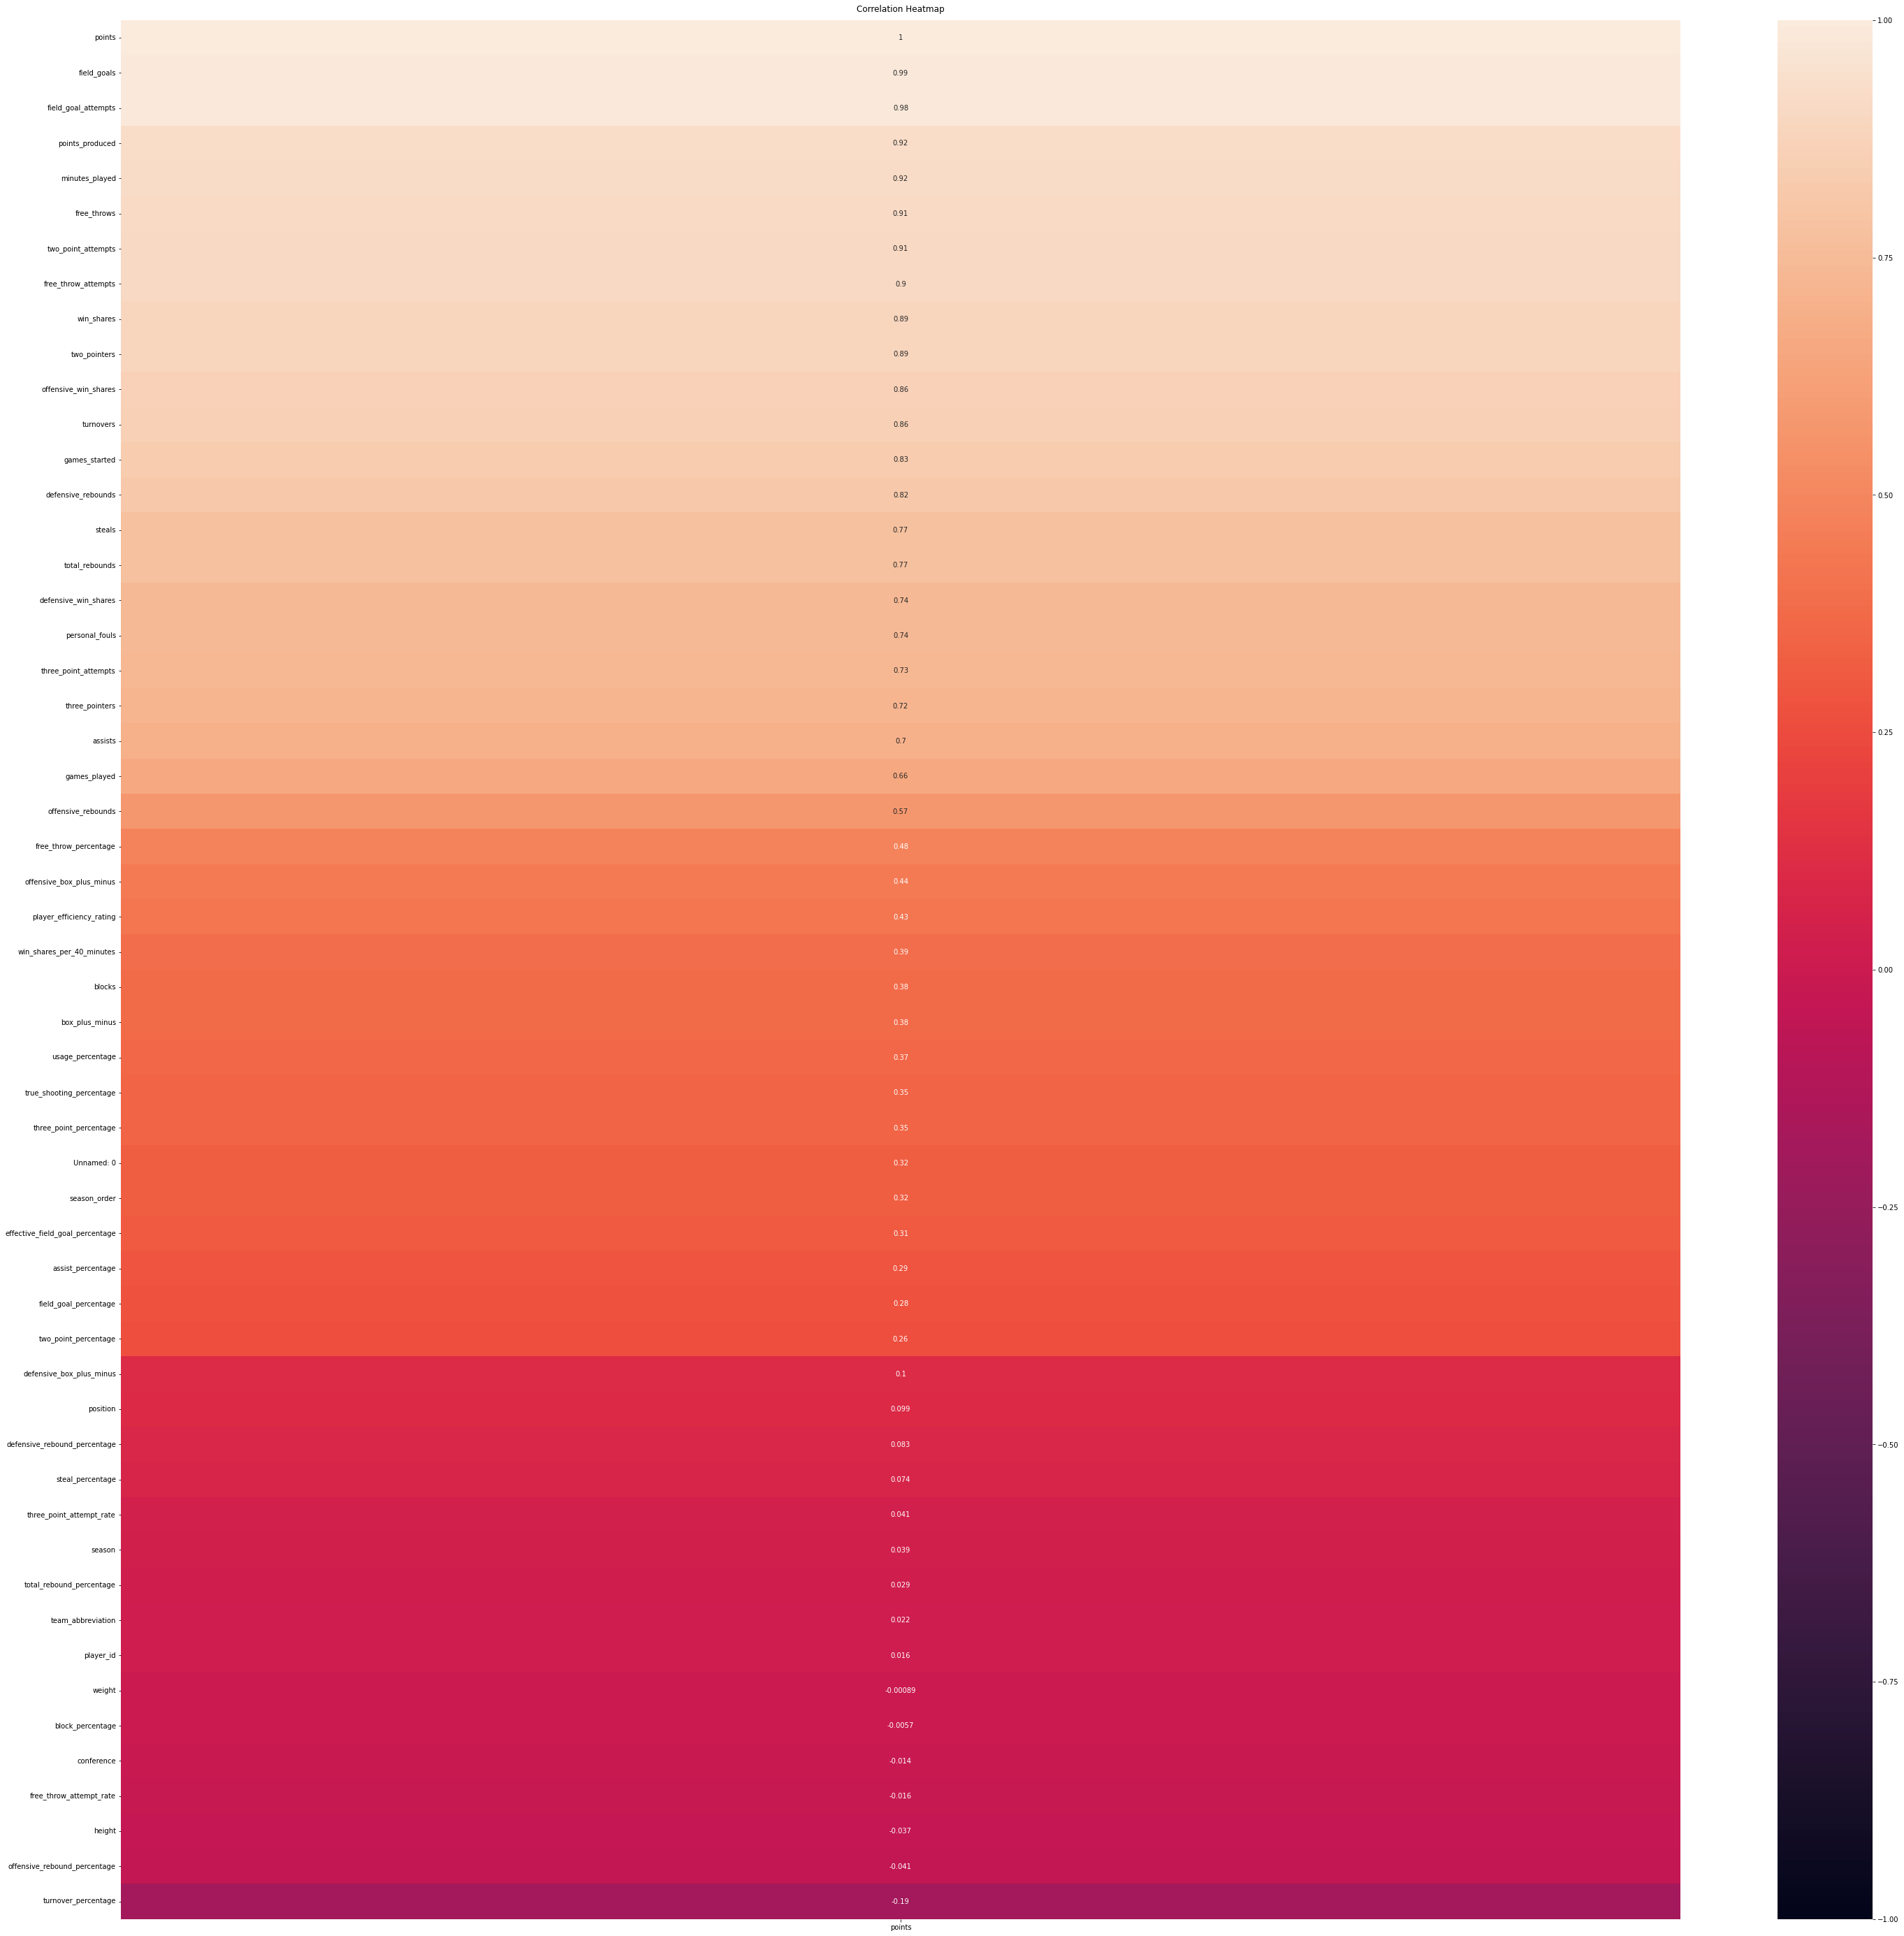

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(50,50))
corr = playerDf.corr()
# corr[['points']].sort_values(by='points', ascending=False)
heatmap = sns.heatmap(corr[['points']].sort_values(by='points', ascending=False), vmin=-1, vmax=1,annot=True)
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12);

#corelation with output variable
cor_target = abs(corr["points"])

#selecting highly corelated features
relevant_feature = cor_target[cor_target>0.5]
relevant_feature



## Droping some features


In [5]:
playerDf.shape
new_player_df = playerDf.copy()
new_player_df.drop(['turnover_percentage','offensive_rebound_percentage','height','free_throw_attempt_rate'
                   ,'conference','block_percentage','weight','player_id','team_abbreviation','total_rebound_percentage','season'
                   ,'three_point_attempt_rate'],axis=1,inplace=True)


# feature selection on new dataframe


In [6]:
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest,f_regression
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
import plotly.express as plt

y = new_player_df['points']
X = new_player_df.drop(['points','field_goals','field_goal_attempts','points_produced'],axis=1)

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.33)

def feature_Selection_points(X_train,y_train,X_test):
    fs = SelectKBest(score_func=f_regression,k='all')
    fs.fit(X_train,y_train)
    #tranform train input data
    X_train_fs = fs.transform(X_train)
    #transform test input data
    X_test_fs = fs.transform(X_test)
    return X_train_fs,X_test_fs,fs

#feature selection
X_train_fs,X_test_fs,fs = feature_Selection_points(X_train,y_train,X_test)

#fit model
model = LinearRegression()
model.fit(X_train_fs,y_train)

#evalue a model
y_predict = model.predict(X_test_fs)

# evaluate predictions
mae = mean_absolute_error(y_test, y_predict)
print('MAE: %.3f' % mae)

# what are scores for the features
for i in range(len(fs.scores_)):
	print('Feature%d %s: %f' % (i, fs.feature_names_in_[i], fs.scores_[i]))
fig = plt.bar(x=[i for i in range(len(fs.scores_))],y=fs.scores_,text=fs.feature_names_in_)
fig.show()




MAE: 0.000
Feature0 Unnamed: 0: 5025.490494
Feature1 assist_percentage: 3756.823121
Feature2 assists: 41058.519793
Feature3 blocks: 6826.718073
Feature4 box_plus_minus: 7101.300273
Feature5 defensive_box_plus_minus: 473.480009
Feature6 defensive_rebound_percentage: 303.386450
Feature7 defensive_rebounds: 87761.881162
Feature8 defensive_win_shares: 51700.253501
Feature9 effective_field_goal_percentage: 4290.508636
Feature10 field_goal_percentage: 3464.313249
Feature11 free_throw_attempts: 180432.294370
Feature12 free_throw_percentage: 13023.443077
Feature13 free_throws: 207919.286497
Feature14 games_played: 33031.541350
Feature15 games_started: 96459.760437
Feature16 minutes_played: 226670.055163
Feature17 offensive_box_plus_minus: 10670.001600
Feature18 offensive_rebounds: 20727.124871
Feature19 offensive_win_shares: 120592.985663
Feature20 personal_fouls: 50201.026337
Feature21 player_efficiency_rating: 9568.326431
Feature22 position: 419.874116
Feature23 steal_percentage: 225.035307


In [7]:
droped_features = ['points','field_goals','field_goal_attempts','points_produced','free_throw_attempts','free_throws'
                  ,'two_point_attempts','two_pointers','win_shares','minutes_played']

In [8]:
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest,f_regression
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
import plotly.express as plt


y = new_player_df['points']
X = new_player_df.drop(droped_features,axis=1)

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.33)

def feature_Selection_points(X_train,y_train,X_test):
    fs = SelectKBest(score_func=f_regression,k='all')
    fs.fit(X_train,y_train)
    #tranform train input data
    X_train_fs = fs.transform(X_train)
    #transform test input data
    X_test_fs = fs.transform(X_test)
    return X_train_fs,X_test_fs,fs

#feature selection
X_train_fs,X_test_fs,fs = feature_Selection_points(X_train,y_train,X_test)

#fit model
model = LinearRegression()
model.fit(X_train_fs,y_train)

#evalue a model
y_predict = model.predict(X_test_fs)

# evaluate predictions
mae = mean_absolute_error(y_test, y_predict)
print('MAE: %.3f' % mae)

# what are scores for the features
for i in range(len(fs.scores_)):
	print('Feature%d %s: %f' % (i, fs.feature_names_in_[i], fs.scores_[i]))
fig = plt.bar(x=[i for i in range(len(fs.scores_))],y=fs.scores_,text=fs.feature_names_in_)
fig.show()



MAE: 18.412
Feature0 Unnamed: 0: 4908.156735
Feature1 assist_percentage: 3747.436473
Feature2 assists: 39829.488071
Feature3 blocks: 7114.315237
Feature4 box_plus_minus: 7077.031416
Feature5 defensive_box_plus_minus: 455.303699
Feature6 defensive_rebound_percentage: 304.372710
Feature7 defensive_rebounds: 86424.641332
Feature8 defensive_win_shares: 50950.761851
Feature9 effective_field_goal_percentage: 4297.636975
Feature10 field_goal_percentage: 3481.622179
Feature11 free_throw_percentage: 12686.323561
Feature12 games_played: 32831.303508
Feature13 games_started: 95777.456353
Feature14 offensive_box_plus_minus: 10667.954323
Feature15 offensive_rebounds: 20787.695974
Feature16 offensive_win_shares: 119687.257382
Feature17 personal_fouls: 50447.509114
Feature18 player_efficiency_rating: 9595.427561
Feature19 position: 398.177103
Feature20 steal_percentage: 220.919438
Feature21 steals: 64109.595011
Feature22 three_point_attempts: 47352.241588
Feature23 three_point_percentage: 5734.930989

## Random Forest Regressor


In [9]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error
import pandas as pd
import numpy as np
import plotly.express as plt

y = new_player_df['points']
X = new_player_df.drop(droped_features,axis=1)

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3,random_state=1)

#scale train and test with standardscaler
X_train_std = StandardScaler().fit_transform(X_train)
X_test_std = StandardScaler().fit_transform(X_test)

#fit the dimension of the target array
y_train = y_train.values.reshape(-1,1)
y_test = y_test.values.reshape(-1,1)

#build model
forest = RandomForestRegressor()
forest.fit(X_train_std,y_train)

print(forest.score(X_test_std,y_test))

#evalute model
y_predict = forest.predict(X_test_std)


#calculate error
mae = mean_absolute_error(y_test,y_predict)
print('MAE: %.3f' % mae)

#feature importance
pd.DataFrame(zip(X_train.columns,abs(forest.feature_importances_)),columns=["feature","weight"]).sort_values("weight",ascending=False).reset_index(drop=True)


fig = plt.bar(x=[i for i in range(len(forest.feature_importances_))],y=forest.feature_importances_,text=X_train.columns)
fig.show()


/var/folders/f8/3kz66kvx6199cq46wkf9vz1m0000gn/T/ipykernel_6491/2926475416.py:24: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



0.9821913706418807
MAE: 13.510


In [10]:
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest,f_regression
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error

import plotly.express as plt

y = playerDf['points']
X = playerDf.drop(droped_features,axis=1)

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.33)

def feature_Selection_points(X_train,y_train,X_test):
    fs = SelectKBest(score_func=f_regression,k='all')
    fs.fit(X_train,y_train)
    #tranform train input data
    X_train_fs = fs.transform(X_train)
    #transform test input data
    X_test_fs = fs.transform(X_test)
    return X_train_fs,X_test_fs,fs

#feature selection
X_train_fs,X_test_fs,fs = feature_Selection_points(X_train,y_train,X_test)

#fit model
model = LinearRegression()
model.fit(X_train_fs,y_train)

#evalue a model
y_predict = model.predict(X_test_fs)

# evaluate predictions
mae = mean_absolute_error(y_test, y_predict)
print('MAE: %.3f' % mae)

# what are scores for the features
for i in range(len(fs.scores_)):
	print('Feature%d %s: %f' % (i, fs.feature_names_in_[i], fs.scores_[i]))
fig = plt.bar(x=[i for i in range(len(fs.scores_))],y=fs.scores_)
fig.show()
    


MAE: 17.648
Feature0 Unnamed: 0: 4980.768251
Feature1 player_id: 12.322170
Feature2 team_abbreviation: 18.987024
Feature3 season: 62.548624
Feature4 assist_percentage: 3657.212315
Feature5 assists: 40198.636620
Feature6 block_percentage: 0.573829
Feature7 blocks: 6889.348034
Feature8 box_plus_minus: 6995.406792
Feature9 conference: 6.082210
Feature10 defensive_box_plus_minus: 471.792845
Feature11 defensive_rebound_percentage: 266.764714
Feature12 defensive_rebounds: 86749.111855
Feature13 defensive_win_shares: 50957.224864
Feature14 effective_field_goal_percentage: 4313.561669
Feature15 field_goal_percentage: 3520.501347
Feature16 free_throw_attempt_rate: 14.446053
Feature17 free_throw_percentage: 12544.404674
Feature18 games_played: 32510.336013
Feature19 games_started: 94241.277576
Feature20 height: 62.463348
Feature21 offensive_box_plus_minus: 10470.006154
Feature22 offensive_rebound_percentage: 79.554076
Feature23 offensive_rebounds: 20632.128005
Feature24 offensive_win_shares: 119

In [11]:
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest,f_regression
import plotly.express as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error

y = playerDf['points']
X = playerDf.drop(droped_features,axis=1)

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.33)

def feature_Selection_points(X_train,y_train,X_test):
    fs = SelectKBest(score_func=f_regression,k='all')
    fs.fit(X_train,y_train)
    #tranform train input data
    X_train_fs = fs.transform(X_train)
    #transform test input data
    X_test_fs = fs.transform(X_test)
    return X_train_fs,X_test_fs,fs

#feature selection
X_train_fs,X_test_fs,fs = feature_Selection_points(X_train,y_train,X_test)


#fit model
model = LinearRegression()
model.fit(X_train_fs,y_train)

#evalue a model
y_predict = model.predict(X_test_fs)

# evaluate predictions
mae = mean_absolute_error(y_test, y_predict)
print('MAE: %.3f' % mae)

# what are scores for the features
for i in range(len(fs.scores_)):
	print('Feature%d %s: %f' % (i, fs.feature_names_in_[i], fs.scores_[i]))
fig = plt.bar(x=[i for i in range(len(fs.scores_))],y=fs.scores_)
fig.show()

MAE: 17.480
Feature0 Unnamed: 0: 4937.855655
Feature1 player_id: 10.888258
Feature2 team_abbreviation: 15.151899
Feature3 season: 75.517871
Feature4 assist_percentage: 3742.038598
Feature5 assists: 40075.919874
Feature6 block_percentage: 0.714412
Feature7 blocks: 6977.083537
Feature8 box_plus_minus: 6873.132559
Feature9 conference: 13.954598
Feature10 defensive_box_plus_minus: 474.189150
Feature11 defensive_rebound_percentage: 278.250588
Feature12 defensive_rebounds: 86612.256237
Feature13 defensive_win_shares: 50725.187682
Feature14 effective_field_goal_percentage: 4276.846548
Feature15 field_goal_percentage: 3393.806464
Feature16 free_throw_attempt_rate: 19.930463
Feature17 free_throw_percentage: 12606.219930
Feature18 games_played: 32974.263370
Feature19 games_started: 95755.668479
Feature20 height: 49.029088
Feature21 offensive_box_plus_minus: 10073.822032
Feature22 offensive_rebound_percentage: 87.908313
Feature23 offensive_rebounds: 20603.847556
Feature24 offensive_win_shares: 11

## Polynomial regression


In [12]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
import numpy as np

y = new_player_df['points']
X = new_player_df.drop(droped_features,axis=1)

poly = PolynomialFeatures(degree=2,include_bias=False)
ploy_features = poly.fit_transform(X)

X_train,X_test,y_train,y_test = train_test_split(ploy_features,y,test_size=0.33)

poly_reg_model = LinearRegression()
poly_reg_model.fit(X_train,y_train)

y_predicted = poly_reg_model.predict(X_test)
print(y_predicted)

# evaluate predictions
mae = mean_absolute_error(y_test, y_predicted)
rmae = np.sqrt(mae)
print('MAE: %.3f' % mae)
print('RMAE: %.3f' % rmae)


## Linear regression

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
import numpy as np

y = new_player_df['points']
X = new_player_df.drop(droped_features,axis=1)

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.33)

poly_reg_model = LinearRegression()
poly_reg_model.fit(X_train,y_train)

y_predicted = poly_reg_model.predict(X_test)
print(y_predicted)

# evaluate predictions
mae = mean_absolute_error(y_test, y_predicted)
rmae = np.sqrt(mae)
print('MAE: %.3f' % mae)
print('RMAE: %.3f' % rmae)

